# Dependencies

In [1]:
import numpy as np
import pandas as pd
from rapidfuzz import process
import yfinance as yf

# import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl

np.set_printoptions(precision=3)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["figure.figsize"] = (30, 5)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

import warnings

warnings.simplefilter("ignore")

C:\Users\Edmund Chia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import wrds
# conn = wrds.Connection()

# Wrangling

In [3]:
cds = pd.read_parquet("data/cds.parquet")
cds["Date"] = pd.to_datetime(cds["Date"])

In [4]:
RR = 0.4

for i in range(1, 11):
    cds[f"{i}y_CDS_spread_%"] = cds[f"PX{i}"] / 100
    cds[f"{i}y_hazard_rate_%"] = cds[f"{i}y_CDS_spread_%"] / (1 - RR)
    cds[f"{i}y_PD"] = (1 - np.exp(-cds[f"{i}y_hazard_rate_%"] / 100 * 5)) * 100

In [5]:
PD = cds[
    ["Date", "Ticker", "Company"] + [col for col in cds.columns if "PD" in col]
].copy()
PD["period"] = pd.PeriodIndex(PD["Date"], freq="Q")
PD["Company"] = PD["Company"].str.upper()
PD

,Date,Ticker,Company,1y_PD,2y_PD,3y_PD,4y_PD,5y_PD,6y_PD,7y_PD,8y_PD,9y_PD,10y_PD,period
0,2015-01-01,A,AGILENT TECHNOLOGIES INC,1.230,2.066,3.202,5.958,6.939,8.858,9.960,11.330,12.381,13.078,2015Q1
1,2015-01-02,A,AGILENT TECHNOLOGIES INC,1.230,2.074,3.211,5.949,6.947,8.874,9.975,11.336,12.393,13.091,2015Q1
2,2015-01-05,A,AGILENT TECHNOLOGIES INC,1.115,2.059,3.223,5.682,7.091,8.909,9.897,11.246,12.292,12.979,2015Q1
3,2015-01-06,A,AGILENT TECHNOLOGIES INC,1.286,2.052,3.222,5.877,7.311,9.260,10.334,11.777,12.894,13.634,2015Q1
4,2015-01-07,A,AGILENT TECHNOLOGIES INC,1.260,2.103,3.300,5.971,7.419,9.349,10.412,11.834,12.935,13.663,2015Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061162,2021-09-06,ZIGGO,ZIGGO,3.530,6.994,10.231,13.410,16.395,19.929,22.252,23.855,25.038,25.943,2021Q3
1061163,2021-09-07,ZIGGO,ZIGGO,3.530,6.971,10.487,13.674,16.915,20.621,23.021,24.656,25.853,26.760,2021Q3
1061164,2021-09-08,ZIGGO,ZIGGO,3.465,6.958,10.383,13.818,16.991,20.651,23.025,24.645,25.831,26.732,2021Q3
1061165,2021-09-09,ZIGGO,ZIGGO,3.506,6.930,10.387,13.702,16.855,20.511,22.886,24.512,25.704,26.609,2021Q3


### Mapping Tickers
Tickers need to be mapped to obtain gvkey

In [6]:
# ticker_mapping = conn.raw_sql(
#     """
#     SELECT
#         t1.gvkey, tic, cik, conm
#     FROM
#         (SELECT
#             gvkey, tic
#         FROM
#             crsp_a_ccm.sechead) t1
#             LEFT JOIN
#         (SELECT
#             gvkey, cik, conm
#         FROM
#             crsp_a_ccm.comphead) t2 ON t1.gvkey = t2.gvkey
#     """
# )
# ticker_mapping.to_csv('ticker_mapping.csv',index = False)

In [7]:
ticker_mapping = pd.read_csv("data/ticker_mapping.csv")

In [8]:
def match_company_name(company_name, company_list, threshold=95):
    match = process.extractOne(company_name, company_list, score_cutoff=threshold)
    return match[0] if match else None


In [9]:
df_tickers = PD[["Ticker", "Company"]].drop_duplicates().reset_index(drop=True)
company_list = df_tickers["Company"].tolist()
master = (
    ticker_mapping[["gvkey", "conm"]]
    .drop_duplicates()
    .reset_index(drop=True)["conm"]
    .tolist()
)
matched = []

In [10]:
for company in company_list:
    matched.append(match_company_name(company, master))

df_tickers["matched_co"] = matched
cleaned_mapping = (
    pd.merge(
        df_tickers, ticker_mapping, how="left", left_on="matched_co", right_on="conm"
    )[["Company", "conm", "gvkey"]]
    .drop_duplicates(subset="gvkey")
    .dropna()
)

gvkeys = cleaned_mapping["gvkey"].tolist()

In [11]:
cleaned_mapping

,Company,conm,gvkey
0,AGILENT TECHNOLOGIES INC,AGILENT TECHNOLOGIES INC,126554.000
1,ANGLO AMERICAN PLC,ANGLO AMERICAN PLC,15508.000
4,APPLE INC,APPLE INC,1690.000
5,ABB LTD,ABB LTD,210418.000
8,ABBVIE INC,ABBVIE INC,16101.000
...,...,...,...
1376,WILLIAMS COS INC,WILLIAMS COS INC,11506.000
1380,WESTPAC BANKING CORP,WESTPAC BANKING CORP,15362.000
1383,WESTERN UNION CO THE,WESTERN UNION CO,175263.000
1384,WEYERHAEUSER CO,WEYERHAEUSER CO,11456.000


In [12]:
PD = pd.merge(
    PD, cleaned_mapping, how="left", left_on="Company", right_on="Company"
).dropna()
PD["gvkey"] = PD["gvkey"].astype(int)

### Retrieve fundamentals by gvkey using wrds

In [13]:
# ratios = conn.raw_sql(
#     f"""
#     SELECT
#         *
#     FROM
#         wrdsapps_finratio.firm_ratio
#     WHERE
#         gvkey IN {tuple(gvkeys)}
#             AND public_date BETWEEN '2015-01-01' AND '2021-12-31'
#     """
# )

# ratios.to_csv("ratios.csv", index=False)

In [14]:
ratios = pd.read_csv("data/ratios.csv")
ratios["public_date"] = pd.to_datetime(ratios["public_date"]) + pd.tseries.offsets.BDay(
    1
)

financial_ratios_metadata = pd.read_csv("data/financial_ratios_metadata.csv")

In [15]:
# column name mappings
financial_ratios_metadata_mapping = (
    financial_ratios_metadata[["Variable Name", "Description"]]
    .set_index("Variable Name")
    .to_dict()["Description"]
)

In [16]:
mapped_ratios_col = []
for col in ratios.columns:
    mapped_ratios_col.append(financial_ratios_metadata_mapping.get(col, col))
ratios.columns = mapped_ratios_col

In [17]:
display(ratios.head())

,gvkey,permno,adate,qdate,public_date,Shillers Cyclically Adjusted P/E Ratio (capei),be,Book/Market (bm),Enterprise Value Multiple (evm),"Price/Operating Earnings (Basic, Excl. EI) (pe_op_basic)",...,ffi30_desc,ffi30,ffi38_desc,ffi38,ffi48_desc,ffi48,ffi49_desc,ffi49,ticker,cusip
0,1078,20482,2013-12-31,2014-09-30,2015-02-02,20.978,22888.000,0.365,16.133,34.431,...,HLTH,8.000,CHEMS,14.000,DRUGS,13.000,DRUGS,13.000,ABT,00282410
1,1078,20482,2014-12-31,2014-12-31,2015-03-02,18.402,22386.000,0.330,16.924,30.172,...,HLTH,8.000,CHEMS,14.000,DRUGS,13.000,DRUGS,13.000,ABT,00282410
2,1078,20482,2014-12-31,2014-12-31,2015-04-01,17.998,22386.000,0.330,16.924,29.510,...,HLTH,8.000,CHEMS,14.000,DRUGS,13.000,DRUGS,13.000,ABT,00282410
3,1078,20482,2014-12-31,2014-12-31,2015-05-01,18.033,22386.000,0.330,16.924,29.567,...,HLTH,8.000,CHEMS,14.000,DRUGS,13.000,DRUGS,13.000,ABT,00282410
4,1078,20482,2014-12-31,2015-03-31,2015-06-01,25.410,21874.000,0.317,16.214,28.929,...,HLTH,8.000,CHEMS,14.000,DRUGS,13.000,DRUGS,13.000,ABT,00282410


In [18]:
drop_col_ratios = ["permno", "adate", "qdate", "ticker", "cusip"] + [
    f"ffi{ffi}" for ffi in [5, 10, 12, 17, 30, 38, 48, 49]
]

ratios = ratios.drop(columns=drop_col_ratios)

In [19]:
# combine ratios
df = pd.merge(
    PD,
    ratios,
    how="left",
    left_on=["Date", "gvkey"],
    right_on=["public_date", "gvkey"],
)

df = (
    df.sort_values(by="Date")
    .groupby(["Ticker", "Company"])[df.columns]
    .ffill()
    .sort_values(by=["Company", "Date"])
)

del PD, ratios

In [20]:
# drop missing rows
missing_value_rows = df.isna().sum(axis=1) / len(df.columns)
df = df[~df.index.isin(missing_value_rows[missing_value_rows > 0.3].index)].reset_index(
    drop=True
)

In [21]:
# drop missing columns
missing_value_columns = df.isna().sum() / len(df)
df = df.drop(
    columns=missing_value_columns[missing_value_columns > 0]
    .sort_values()
    .index.tolist()
)

In [22]:
df.isna().sum().sort_values()

Date                                                             0
Gross Profit/Total Assets (gprof)                                0
Common Equity/Invested Capital (equity_invcap)                   0
Long-term Debt/Invested Capital (debt_invcap)                    0
Total Debt/Invested Capital (totdebt_invcap)                     0
Capitalization Ratio (capital_ratio)                             0
Cash Balance/Total Liabilities (cash_lt)                         0
Total Debt/Total Assets (debt_at)                                0
Short-Term Debt/Total Debt (short_debt)                          0
Long-term Debt/Total Liabilities (lt_debt)                       0
Total Debt/Total Assets (debt_assets)                            0
Total Debt/Equity (de_ratio)                                     0
After-tax Return on Total Stockholders Equity (aftret_equity)    0
Asset Turnover (at_turn)                                         0
Research and Development/Sales (rd_sale)                      

In [23]:
df = df.drop(
    columns=[
        "Ticker",
        "1y_PD",
        "2y_PD",
        "3y_PD",
        "4y_PD",
        "6y_PD",
        "7y_PD",
        "8y_PD",
        "9y_PD",
        "10y_PD",
        "period",
        "conm",
        "gvkey",
        "public_date"
    ]
).set_index(["Date", "Company"])

# Feature Engineering

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [25]:
random_state = 634
train_prop = 0.7

In [26]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type is not object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

In [27]:
Y = df["5y_PD"]
X = df.drop(columns="5y_PD")
X.columns = X.columns.str.replace(
    r"[^a-zA-Z0-9_]", "_", regex=True
)  # lgbm cant handle columns with some random characters

In [28]:
bond_yield_tickers = [
    "^VIX",  # CBOE VIX
    "^TNX",  # 10-year U.S. Treasury Yield
    "^IRX",  # 2-year U.S. Treasury Yield
    "^TYX",  # 30-year U.S. Treasury Yield
    "^FVX",  # 5-year U.S. Treasury Yield
    "TLT",  # iShares 20+ Year Treasury Bond ETF
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF
    "HYG",  # iShares iBoxx $ High Yield Corporate Bond ETF
    "MUB",  # iShares National Muni Bond ETF
    "TIP",  # iShares TIPS Bond ETF
    "EMB",  # iShares J.P. Morgan USD Emerging Markets Bond ETF
    "IGOV",  # iShares International Government Bond ETF
]

exogeneous = yf.download(bond_yield_tickers)["Adj Close"]
exogeneous.index = pd.to_datetime(exogeneous.index)

[*********************100%%**********************]  12 of 12 completed


In [29]:
dates = X.index.get_level_values("Date").unique().tolist()
days = len(dates)
train_days = dates[: int(train_prop * days)]

X_train, X_test, y_train, y_test = (
    X[X.index.get_level_values("Date").isin(train_days)],
    X[~X.index.get_level_values("Date").isin(train_days)],
    Y[Y.index.get_level_values("Date").isin(train_days)],
    Y[~Y.index.get_level_values("Date").isin(train_days)],
)

In [30]:
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

cat_cols = X_train.select_dtypes(include=["object"]).columns
encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
X_train_encoder = encoder.fit_transform(X_train[cat_cols])
X_train_encoded_df = pd.DataFrame(
    X_train_encoder.toarray(), columns=encoder.get_feature_names_out(cat_cols)
)
X_train_encoded_df.index = X_train.index
X_train = pd.concat([X_train.drop(columns=cat_cols), X_train_encoded_df], axis=1)

In [31]:
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test_encoder = encoder.transform(X_test[cat_cols])
X_test_encoded_df = pd.DataFrame(
    X_test_encoder.toarray(), columns=encoder.get_feature_names_out(cat_cols)
)
X_test_encoded_df.index = X_test.index
X_test = pd.concat([X_test.drop(columns=cat_cols), X_test_encoded_df], axis=1)

In [32]:
X_train = pd.merge(
    X_train, exogeneous, how="left", left_index=True, right_index=True
).ffill()
X_test = pd.merge(
    X_test, exogeneous, how="left", left_index=True, right_index=True
).ffill()

In [33]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 156.89 MB
Memory usage after optimization is: 39.83 MB
Decreased by 74.61%
Memory usage of dataframe is 69.25 MB
Memory usage after optimization is: 17.62 MB
Decreased by 74.56%


In [34]:
del df

# Modelling

In [35]:
from sklearn.model_selection import cross_val_score, KFold

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import optuna
import shap

In [36]:
numfolds = 10
scoring = "neg_mean_squared_error"

names = []

kfold_results = []

train_results = []
test_results = []

trained_model = []

In [37]:
def run_kfold(model):
    kfold = KFold(n_splits=numfolds, shuffle=False)

    cv_results = -1 * cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring
    )

    return cv_results

### Baseline Models

In [38]:
baseline_models = []

baseline_models.append(
    (
        "LGBR",
        lgb.LGBMRegressor(
            random_state=random_state,
            device="gpu",
            verbose=-1,
        ),
    )
)
baseline_models.append(
    ("XGBR", xgb.XGBRegressor(random_state=random_state, device="gpu"))
)

In [39]:
for name, model in baseline_models:
    names.append(f"baseline_{name}")

    cv_results = run_kfold(model=model)

    kfold_results.append(cv_results)

    res = model.fit(X_train, y_train)

    trained_model.append(res)

    train_result = mean_squared_error(res.predict(X_train), y_train)

    train_results.append(train_result)

    test_result = mean_squared_error(res.predict(X_test), y_test)

    test_results.append(test_result)
    message = "%s: %f (%f) %f %f" % (
        name,
        np.nanmean(cv_results),
        np.nanstd(cv_results),
        train_result,
        test_result,
    )
    print(message)

LGBR: 14.117869 (8.801551) 0.590269 15.407856
XGBR: 14.096128 (8.702644) 0.221174 14.427444


### Tuning Models

In [ ]:
def objective_function(config, model_type):
    if model_type == "xgboost":
        model = xgb.XGBRegressor(**config)
    elif model_type == "lightgbm":
        model = lgb.LGBMRegressor(**config)

    # Cross-validation with KFold
    cv_results = run_kfold(model=model)

    return np.nanmean(cv_results)


# Optuna objective function for XGBoost
def optuna_objective_xgb(trial):
    config = {
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "gamma": trial.suggest_float("gamma", 0, 0.2),
        "device": "gpu",
        "random_state": random_state,
    }
    return objective_function(config, model_type="xgboost")


# Optuna objective function for LightGBM
def optuna_objective_lgb(trial):
    config = {
        "num_leaves": trial.suggest_int("num_leaves", 31, 80),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "device": "gpu",
        "random_state": random_state,
        "verbose": -1,
    }
    return objective_function(config, model_type="lightgbm")

In [ ]:
# Optuna optimization for LightGBM
study_lgb = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
study_lgb.optimize(optuna_objective_lgb, n_trials=100, n_jobs=2)

print(f"Best parameters for LightGBM: {study_lgb.best_params}")
print(f"Best MSE for LightGBM: {study_lgb.best_value}")

[I 2024-12-12 04:20:26,516] A new study created in memory with name: no-name-997d9025-80d7-4286-b1e9-69213f22a655
[I 2024-12-12 04:20:47,767] Trial 1 finished with value: 13.586082605817202 and parameters: {'num_leaves': 74, 'learning_rate': 0.0537467956919066, 'n_estimators': 58, 'max_depth': 5, 'subsample': 0.8423417327650666, 'colsample_bytree': 0.8379776416185217}. Best is trial 1 with value: 13.586082605817202.
[I 2024-12-12 04:20:54,133] Trial 0 finished with value: 14.252767472587228 and parameters: {'num_leaves': 68, 'learning_rate': 0.011812639125914523, 'n_estimators': 277, 'max_depth': 3, 'subsample': 0.5064601976143512, 'colsample_bytree': 0.5482901161810858}. Best is trial 1 with value: 13.586082605817202.
[I 2024-12-12 04:21:13,307] Trial 2 finished with value: 14.00747831131947 and parameters: {'num_leaves': 49, 'learning_rate': 0.08807133847692013, 'n_estimators': 254, 'max_depth': 3, 'subsample': 0.9094870139583071, 'colsample_bytree': 0.7909861805757693}. Best is tria

Best parameters for LightGBM: {'num_leaves': 31, 'learning_rate': 0.04265759401988038, 'n_estimators': 209, 'max_depth': 7, 'subsample': 0.9776781472149549, 'colsample_bytree': 0.6227865535721993}
Best MSE for LightGBM: 12.433467531535879


In [ ]:
# Optuna optimization for XGBoost
study_xgb = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
study_xgb.optimize(optuna_objective_xgb, n_trials=100, n_jobs=1)

print(f"Best parameters for XGBoost: {study_xgb.best_params}")
print(f"Best MSE for XGBoost: {study_xgb.best_value}")

[I 2024-12-12 05:10:43,861] A new study created in memory with name: no-name-f2fe26db-a499-4d21-839b-f3fe08358db4
[I 2024-12-12 05:15:10,973] Trial 0 finished with value: 13.53703205209053 and parameters: {'max_depth': 15, 'learning_rate': 0.01222362516032907, 'n_estimators': 147, 'subsample': 0.5805848030023364, 'colsample_bytree': 0.6155790352395394, 'min_child_weight': 3, 'gamma': 0.03589418043166326}. Best is trial 0 with value: 13.53703205209053.
[I 2024-12-12 05:15:26,697] Trial 1 finished with value: 12.92032866319239 and parameters: {'max_depth': 5, 'learning_rate': 0.06206126640426046, 'n_estimators': 112, 'subsample': 0.975539681432958, 'colsample_bytree': 0.5482002702491103, 'min_child_weight': 1, 'gamma': 0.10411882561464361}. Best is trial 1 with value: 12.92032866319239.
[I 2024-12-12 05:15:36,309] Trial 2 finished with value: 14.913066384662494 and parameters: {'max_depth': 5, 'learning_rate': 0.02192018701699698, 'n_estimators': 55, 'subsample': 0.8089007074534038, 'col

Best parameters for XGBoost: {'max_depth': 7, 'learning_rate': 0.03857655589185728, 'n_estimators': 274, 'subsample': 0.8547896140931175, 'colsample_bytree': 0.6148705887274962, 'min_child_weight': 1, 'gamma': 0.11848332244472948}
Best MSE for XGBoost: 12.155888919799684


In [40]:
best_params = {}

# Re-tuned
best_params["LGBR"] = {
    "num_leaves": 31,
    "learning_rate": 0.04265759401988038,
    "n_estimators": 209,
    "max_depth": 7,
    "subsample": 0.9776781472149549,
    "colsample_bytree": 0.6227865535721993,
}

# Re-tuned
best_params["XGBR"] = {
    "max_depth": 7,
    "learning_rate": 0.03857655589185728,
    "n_estimators": 274,
    "subsample": 0.8547896140931175,
    "colsample_bytree": 0.6148705887274962,
    "min_child_weight": 1,
    "gamma": 0.11848332244472948,
}

tuned_models = []
tuned_models.append(
    (
        "LGBR",
        lgb.LGBMRegressor(
            **best_params["LGBR"],
            random_state=random_state,
            device="gpu",
            verbose = -1
        ),
    )
)
tuned_models.append(
    (
        "XGBR",
        xgb.XGBRegressor(
            **best_params["XGBR"], random_state=random_state, device="gpu"
        ),
    )
)

In [41]:
for name, model in tuned_models:
    names.append(f"tuned_{name}")

    cv_results = run_kfold(model=model)

    kfold_results.append(cv_results)

    res = model.fit(X_train, y_train)

    trained_model.append(res)

    train_result = mean_squared_error(res.predict(X_train), y_train)

    train_results.append(train_result)

    test_result = mean_squared_error(res.predict(X_test), y_test)

    test_results.append(test_result)
    message = "%s: %f (%f) %f %f" % (
        name,
        np.nanmean(cv_results),
        np.nanstd(cv_results),
        train_result,
        test_result,
    )
    print(message)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11048
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 107
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (8.53 MB) transferred to GPU in 0.013766 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 5.982166
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves 

## NN Modelling

In [42]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

keras.utils.set_random_seed(random_state)

history_models = []
epochs = 50
batchsize = 8224

In [43]:
def run_kfold_NN(model):
    kfold = KFold(n_splits=numfolds, shuffle=False)

    cv_results = -1 * cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1
    )

    return cv_results

### Baseline Model

In [44]:
def create_ann(shape):
    model = Sequential()

    model.add(Dense(units=256, activation="relu", input_dim=shape))
    model.add(Dropout(0.1))

    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(0.1))

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

    return model

In [45]:
names.append("baseline_NN")

model = create_ann(X_train.shape[1])

# Wrap the Keras model so that it can be used with Scikit-learn's cross_val_score
model_cv = KerasRegressor(
    build_fn=create_ann(X_train.shape[1]),
    epochs=epochs,
    batch_size=batchsize,
)

# Perform cross-validation
cv_results = run_kfold_NN(model=model_cv)

kfold_results.append(cv_results)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batchsize,
    validation_split=0.2,
    callbacks=[early_stopping],
)

trained_model.append(model)
history_models.append(history)

train_result = mean_squared_error(model.predict(X_train), y_train)

train_results.append(train_result)

test_result = mean_squared_error(model.predict(X_test), y_test)

test_results.append(test_result)

message = "%f (%f) %f %f" % (
    np.nanmean(cv_results),
    np.nanstd(cv_results),
    train_result,
    test_result,
)
print(message)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 97.3651 - val_loss: 11.4364
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 39.5927 - val_loss: 11.9391
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 29.8897 - val_loss: 11.9306
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 25.5420 - val_loss: 10.7650
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 22.8559 - val_loss: 11.1806
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 20.8370 - val_loss: 11.1427
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 19.1650 - val_loss: 10.4235
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 17.5960 - val_loss: 10.0083
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 16.0854 - val_loss: 9.6815
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 14.8427 - val_loss: 9.4675
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 13.7266 - val_loss: 9.2334
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33

### Tuning ANN

In [15]:
def objective_function_NN(trial):
    model = Sequential()
    layers = trial.suggest_int("layers", 1, 4)
    init_units = trial.suggest_int("layer_0_units", 32, 512, step=2)

    model.add(Dense(units=init_units, activation="relu", input_dim=X_train.shape[1]))

    prev_units = init_units

    for layer in range(1, layers):
        units = trial.suggest_int(f"layer_{layer}_units", 32, prev_units, step=2)
        model.add(Dropout(0.1))

        prev_units = units

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

    model = KerasRegressor(
        build_fn=model,
        epochs=epochs,
        batch_size=batchsize,
    )

    # Cross-validation with KFold
    cv_results = run_kfold_NN(model=model)

    return np.nanmean(cv_results)

In [16]:
# Optuna optimization for NN
study_NN = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state)
)
study_NN.optimize(objective_function_NN, n_trials=100)

print(f"Best parameters for NN: {study_NN.best_params}")
print(f"Best MSE for NN: {study_NN.best_value}")

[I 2024-12-13 12:15:45,651] A new study created in memory with name: no-name-a7356a1b-fa6b-4ecc-9d90-4a32682887d1
[I 2024-12-13 12:18:50,475] Trial 0 finished with value: 17.8106187394424 and parameters: {'layers': 4, 'layer_0_units': 188, 'layer_1_units': 80, 'layer_2_units': 44, 'layer_3_units': 42}. Best is trial 0 with value: 17.8106187394424.
[I 2024-12-13 12:19:51,915] Trial 1 finished with value: 18.29574240815402 and parameters: {'layers': 3, 'layer_0_units': 64, 'layer_1_units': 58, 'layer_2_units': 46}. Best is trial 0 with value: 17.8106187394424.
[I 2024-12-13 12:24:28,356] Trial 2 finished with value: 20.884230058395907 and parameters: {'layers': 3, 'layer_0_units': 400, 'layer_1_units': 340, 'layer_2_units': 158}. Best is trial 0 with value: 17.8106187394424.
[I 2024-12-13 12:25:09,651] Trial 3 finished with value: 18.46921247446597 and parameters: {'layers': 1, 'layer_0_units': 78}. Best is trial 0 with value: 17.8106187394424.
[I 2024-12-13 12:26:30,172] Trial 4 finishe

Best parameters for NN: {'layers': 4, 'layer_0_units': 354, 'layer_1_units': 242, 'layer_2_units': 82, 'layer_3_units': 50}
Best MSE for NN: 17.19927892123212


In [46]:
names.append("tuned_NN")

units = {
    "layer_0_units": 354,
    "layer_1_units": 242,
    "layer_2_units": 82,
    "layer_3_units": 50,
}

model = Sequential()

model.add(
    Dense(units=units["layer_0_units"], activation="relu", input_dim=X_train.shape[1])
)

for _, unit in units.items():
    model.add(Dense(units=unit, activation="relu"))
    model.add(Dropout(0.1))

model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

# Wrap the Keras model so that it can be used with Scikit-learn's cross_val_score
model_cv = KerasRegressor(
    build_fn=model,
    epochs=epochs,
    batch_size=batchsize,
    verbose=0,
)

# Perform cross-validation
cv_results = run_kfold_NN(model=model_cv)

kfold_results.append(cv_results)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batchsize,
    validation_split=0.2,
)

trained_model.append(model)
history_models.append(history)

train_result = mean_squared_error(model.predict(X_train), y_train)

train_results.append(train_result)

test_result = mean_squared_error(model.predict(X_test), y_test)

test_results.append(test_result)

message = "%f (%f) %f %f" % (
    np.nanmean(cv_results),
    np.nanstd(cv_results),
    train_result,
    test_result,
)
print(message)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 42.9309 - val_loss: 11.5870
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 26.2968 - val_loss: 11.6728
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 24.4272 - val_loss: 10.1974
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 20.5706 - val_loss: 9.1672
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 17.2732 - val_loss: 8.8268
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 14.2696 - val_loss: 8.2888
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 12.5941 - val_loss: 7.3802
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 11.3158 - val_loss: 7.3134
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 10.3160 - val_loss: 9.9846
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 21.2389 - val_loss: 9.6528
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 19.4125 - val_loss: 8.1985
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/st

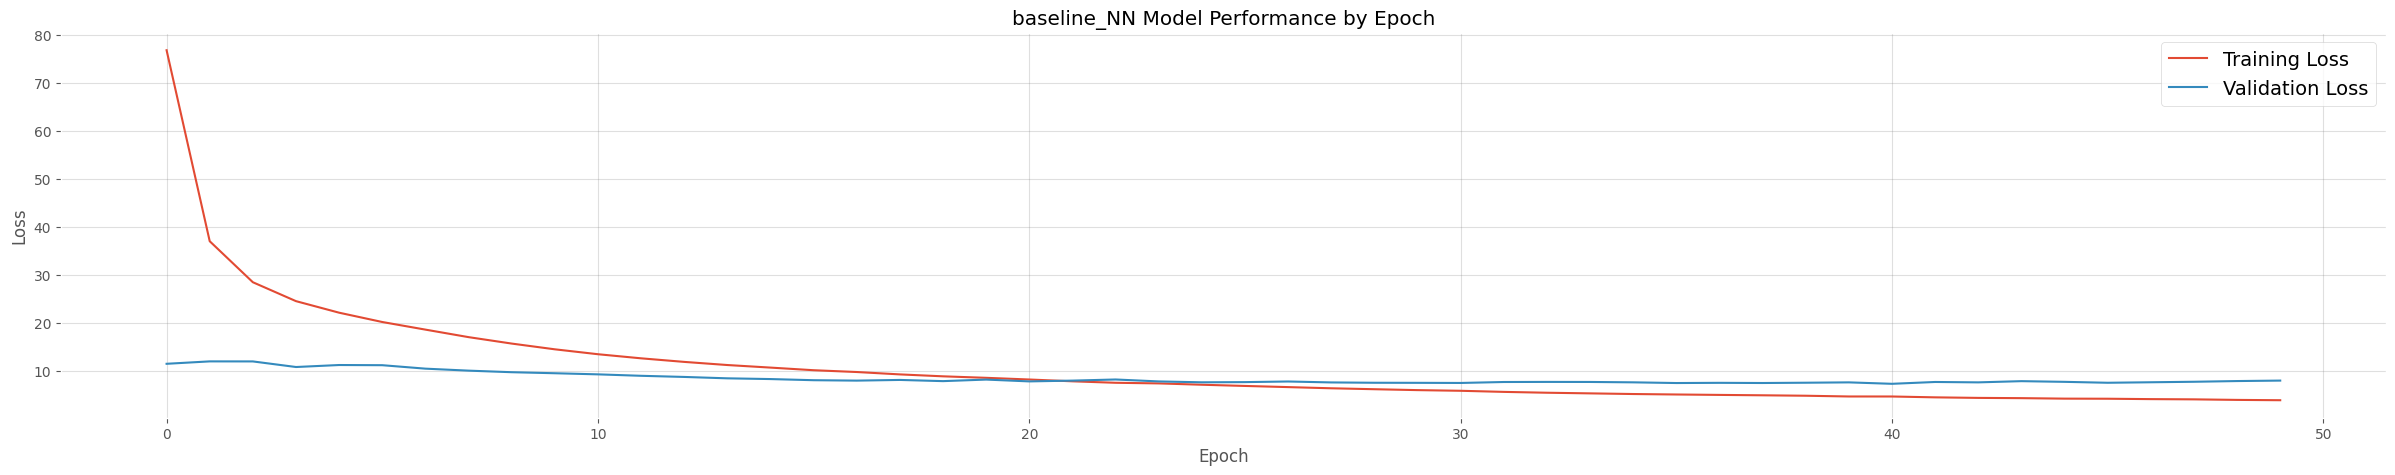

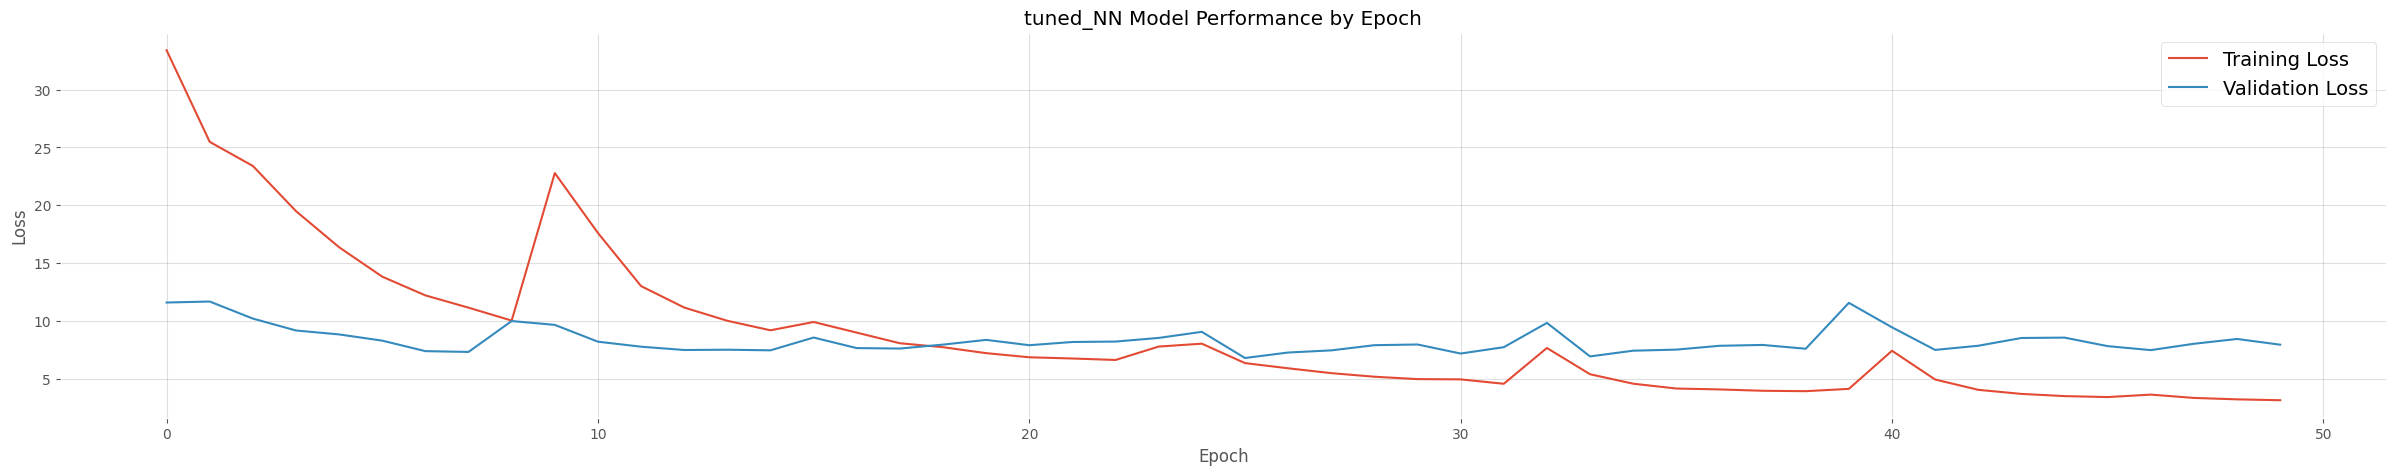

In [47]:
for name, h in zip(names[-2:], history_models):
    plt.plot(h.history["loss"], label="Training Loss")
    plt.plot(h.history["val_loss"], label="Validation Loss")

    plt.title(f"{name} Model Performance by Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Model Predictions

In [48]:
train_preds = X_train.copy()
test_preds = X_test.copy()

for name, model in zip(names, trained_model):
    train_preds[f"{name}_pred"] = model.predict(X_train)
    test_preds[f"{name}_pred"] = model.predict(X_test)

train_preds["5y_PD"] = y_train
test_preds["5y_PD"] = y_test
final_df = (
    pd.concat([train_preds, test_preds]).drop(columns=X_train.columns).reset_index()
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
5975/5975 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [56]:
def compute_se(df):
    y = df["5y_PD"]
    x = df.drop(columns="5y_PD")

    for col in x.columns:
        x[col] = (y - x[col]) ** 2
    return x


train_errors = compute_se(train_preds[["5y_PD"] + [f"{name}_pred" for name in names]])
train_errors["type"] = "train"

test_errors = compute_se(test_preds[["5y_PD"] + [f"{name}_pred" for name in names]])

test_errors["type"] = "test"

errors_df = pd.concat([train_errors, test_errors])

overall_errors = errors_df.groupby("type").mean().sort_index(ascending=False)
company_errors = (
    errors_df.reset_index().drop(columns="Date").groupby(["Company", "type"]).mean()
)

cv_df = []
for name, cv_results in zip(names, kfold_results):
    temp_df = pd.DataFrame.from_dict({'cv_mean': np.nanmean(cv_results), 'cv_std': np.nanstd(cv_results)}, orient='index')
    temp_df.columns = [name]
    cv_df.append(temp_df)
    
cv_df = pd.concat(cv_df, axis = 1)

In [57]:
display(overall_errors)
display(cv_df)
display(company_errors)

,baseline_LGBR_pred,baseline_XGBR_pred,tuned_LGBR_pred,tuned_XGBR_pred,baseline_NN_pred,tuned_NN_pred
type,,,,,,
train,0.590,0.221,0.666,0.282,4.808,4.957
test,15.408,14.427,13.201,13.307,17.036,20.386


,baseline_LGBR,baseline_XGBR,tuned_LGBR,tuned_XGBR,baseline_NN,tuned_NN
cv_mean,14.118,14.096,12.695,12.276,27.727,30.851
cv_std,8.802,8.703,10.055,9.589,33.056,42.637


baseline_LGBR_pred  baseline_XGBR_pred  \
Company              type                                            
3M CO                test                0.037               0.162   
                     train               0.163               0.036   
ABBOTT LABORATORIES  test                0.243               0.562   
                     train               0.220               0.087   
ABBVIE INC           test                5.051               6.868   
...                                        ...                 ...   
WESTERN UNION CO THE train               0.619               0.343   
WHIRLPOOL CORP       test                4.930               7.606   
                     train               0.655               0.236   
WILLIAMS COS INC     test               10.286               9.829   
                     train               2.287               0.723   

                            tuned_LGBR_pred  tuned_XGBR_pred  \
Company              type                                      
3M CO                test             0.064            0.032   
                     train            0.167            0.043   
ABBOTT LABORATORIES  test             0.143            0.105   
                     train            0.269            0.091   
ABBVIE INC           test             4.315            3.942   
...                                     ...              ...   
WESTERN UNION CO THE train            0.631            0.314   
WHIRLPOOL CORP       test             5.463            6.771   
                     train            0.782            0.346   
WILLIAMS COS INC     test            14.135           13.070   
                     train            2.227            0.721   

                            baseline_NN_pred  tuned_NN_pred  
Company              type                                    
3M CO                test              0.318          1.338  
                     train             0.073          0.073  
ABBOTT LABORATORIES  test              0.839          0.897  
                     train             1.424          1.400  
ABBVIE INC           test              7.322          8.804  
...                                      ...            ...  
WESTERN UNION CO THE train            33.873         35.361  
WHIRLPOOL CORP       test             55.040         77.563  
                     train            30.162         23.988  
WILLIAMS COS INC     test             27.895         55.135  
                     train            24.760         22.663  

[327 rows x 6 columns]

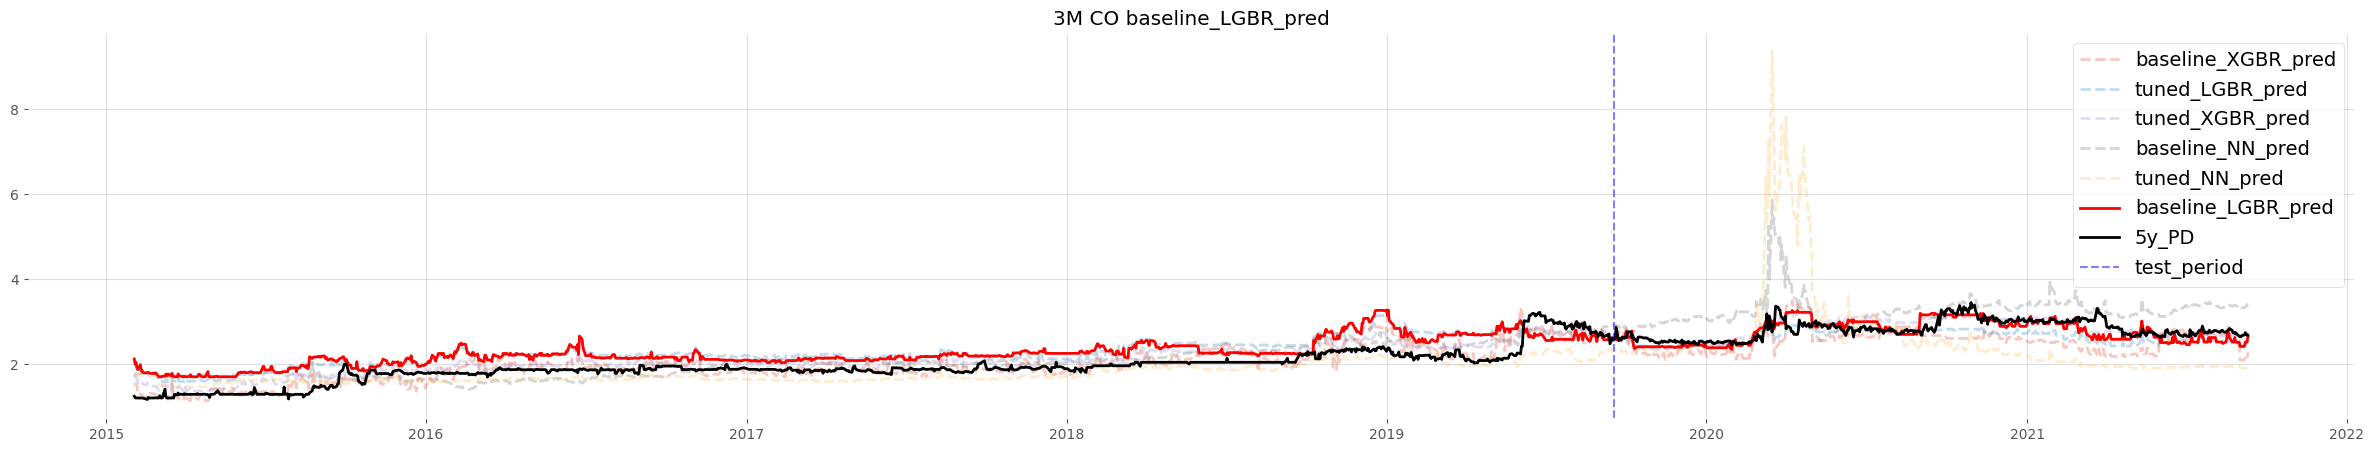

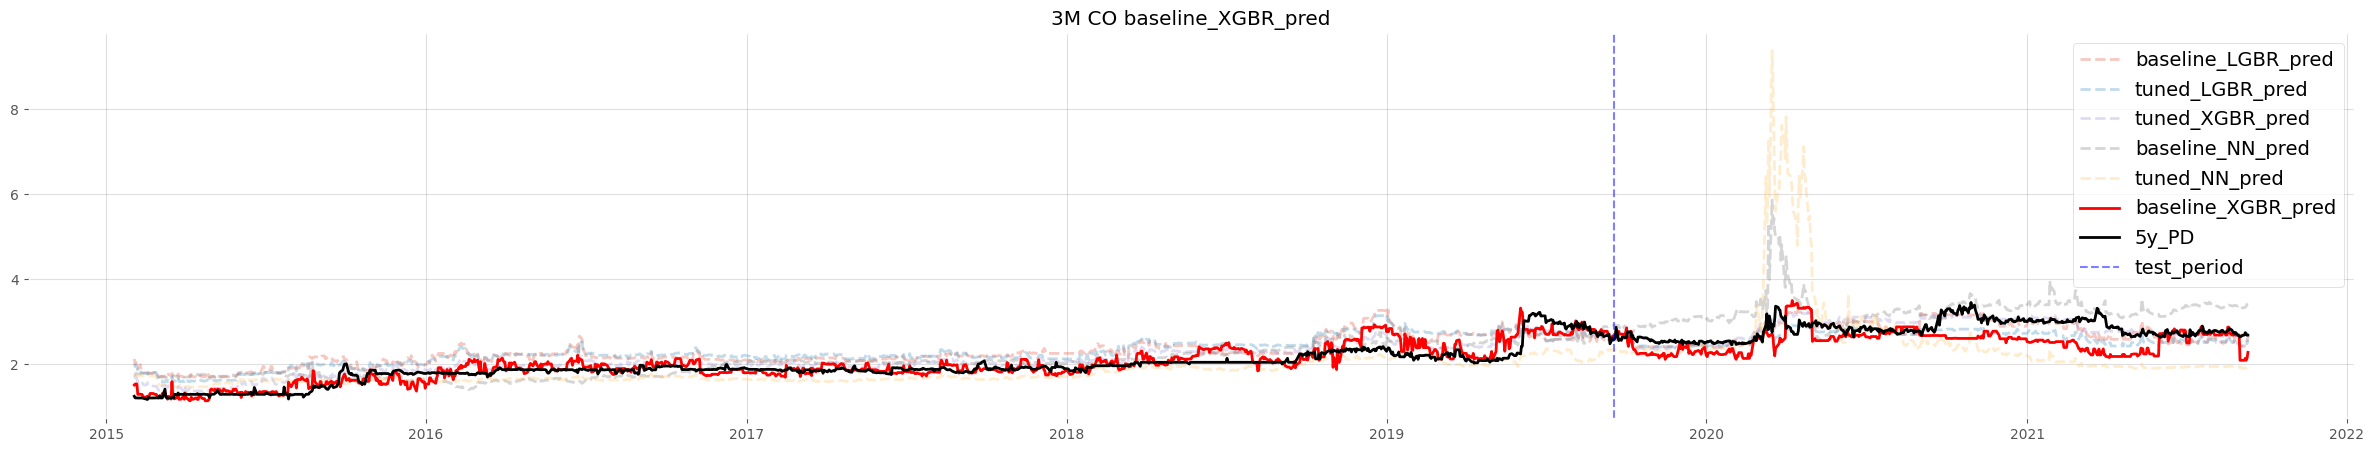

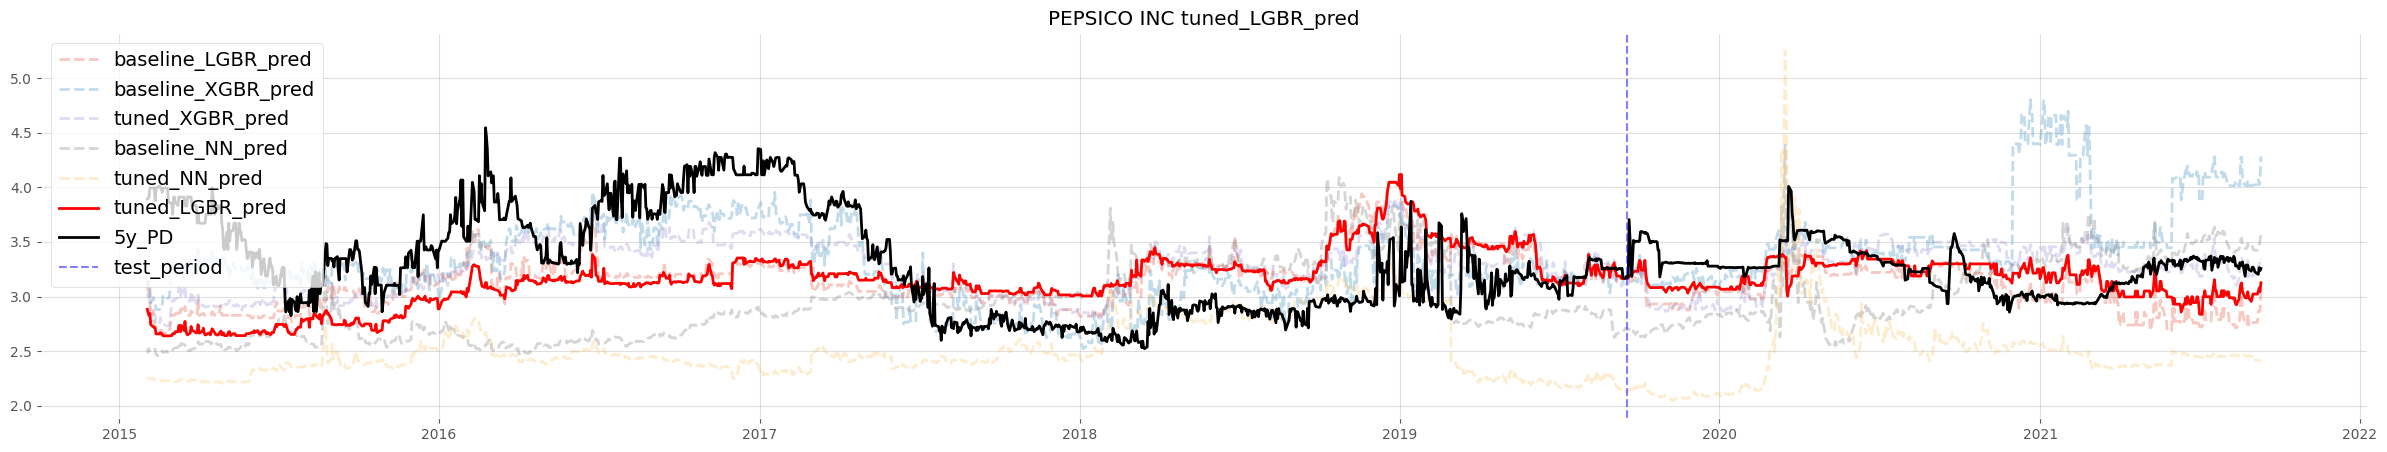

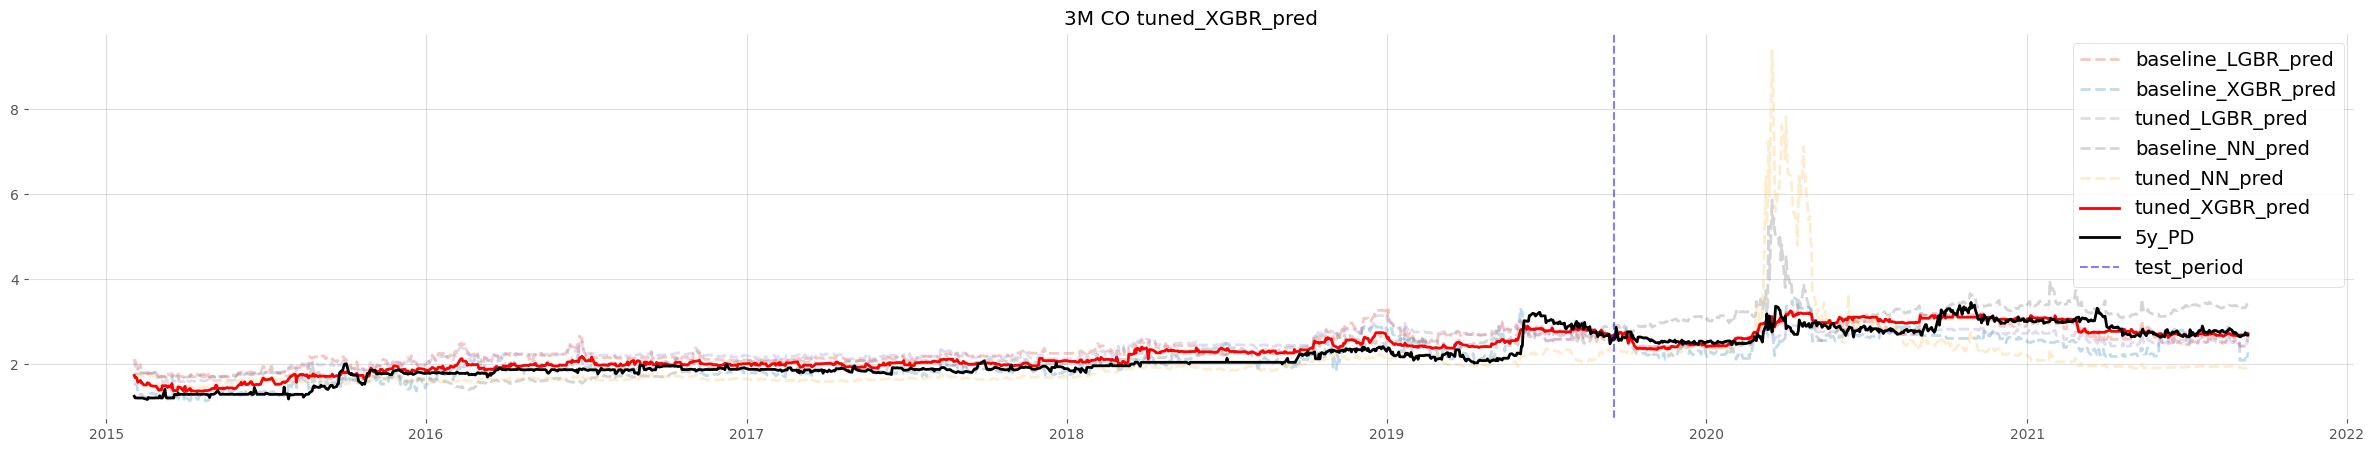

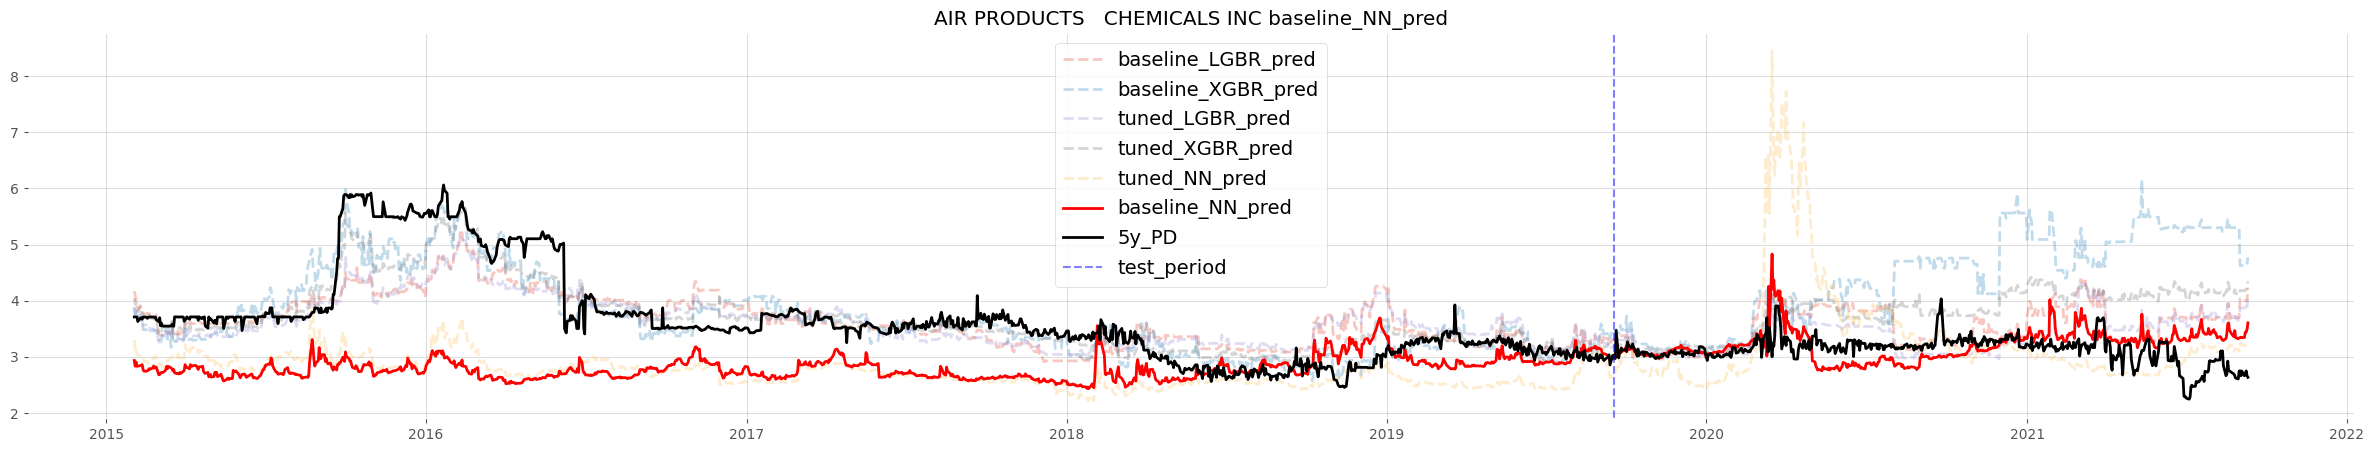

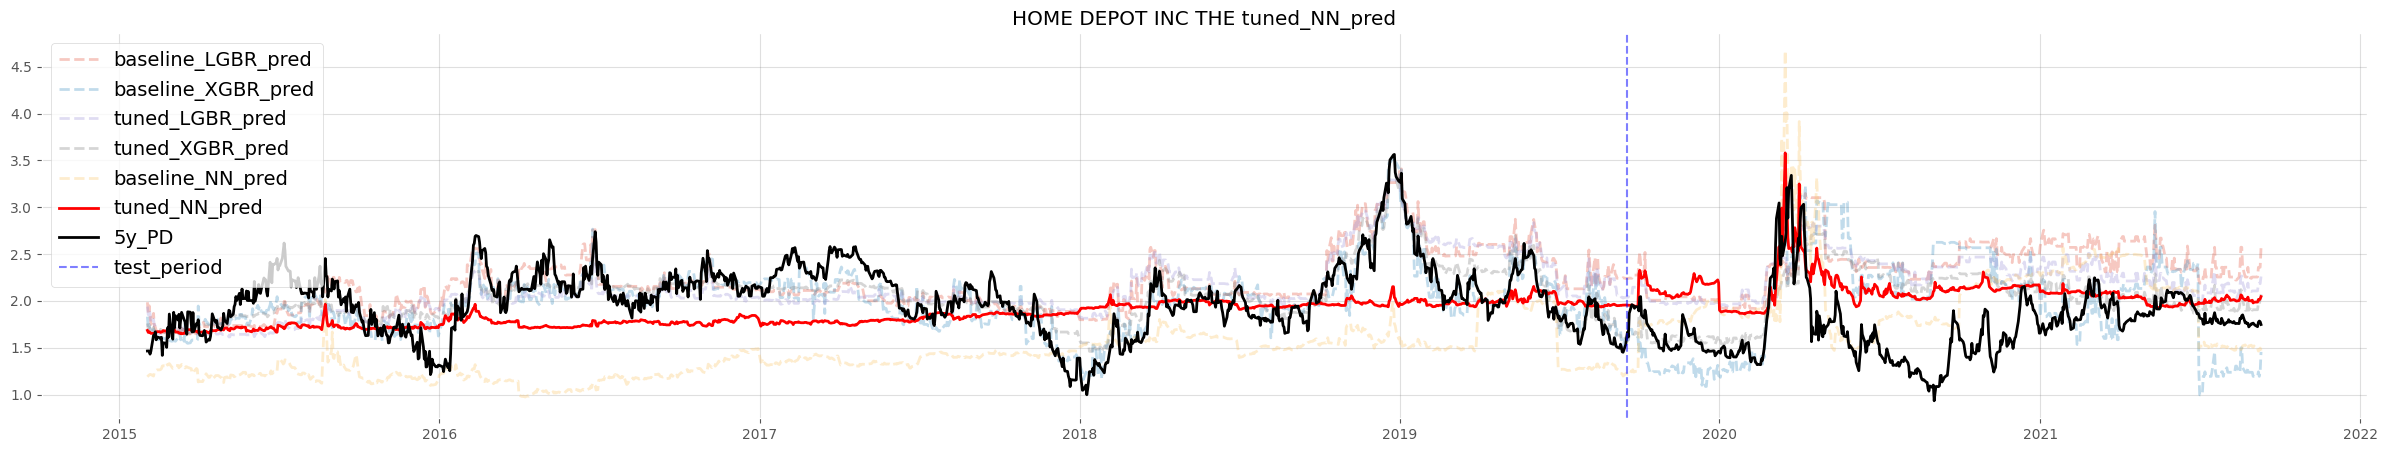

In [58]:
for model_pred in company_errors.columns:
    companys_test_error = company_errors[
        company_errors.index.get_level_values("type") == "test"
    ].reset_index()

    # top company by test result for each model
    company = companys_test_error.sort_values(by=model_pred, ascending=True)[
        "Company"
    ].iloc[0]

    plot_df = final_df[final_df["Company"] == company].set_index("Date")
    plot_df_bg = plot_df[
        [f"{name}_pred" for name in names]
    ].drop(columns=model_pred)

    plt.plot(
        plot_df.index,
        plot_df_bg[plot_df_bg.columns],
        linestyle="--",
        label=plot_df_bg.columns,
        linewidth=2,
        alpha=0.3,
    )

    plt.plot(
        plot_df.index, plot_df[model_pred], color="red", linewidth=2, label=model_pred
    )

    plt.plot(plot_df.index, plot_df["5y_PD"], color="black", linewidth=2, label="5y_PD")

    plt.axvline(
        X_test.index.get_level_values("Date").min(),
        label="test_period",
        linestyle="--",
        color="blue",
        alpha=0.5,
    )
    plt.title(f"{company} {model_pred}")
    plt.legend()
    plt.show()

## Shaply Feature Contribution

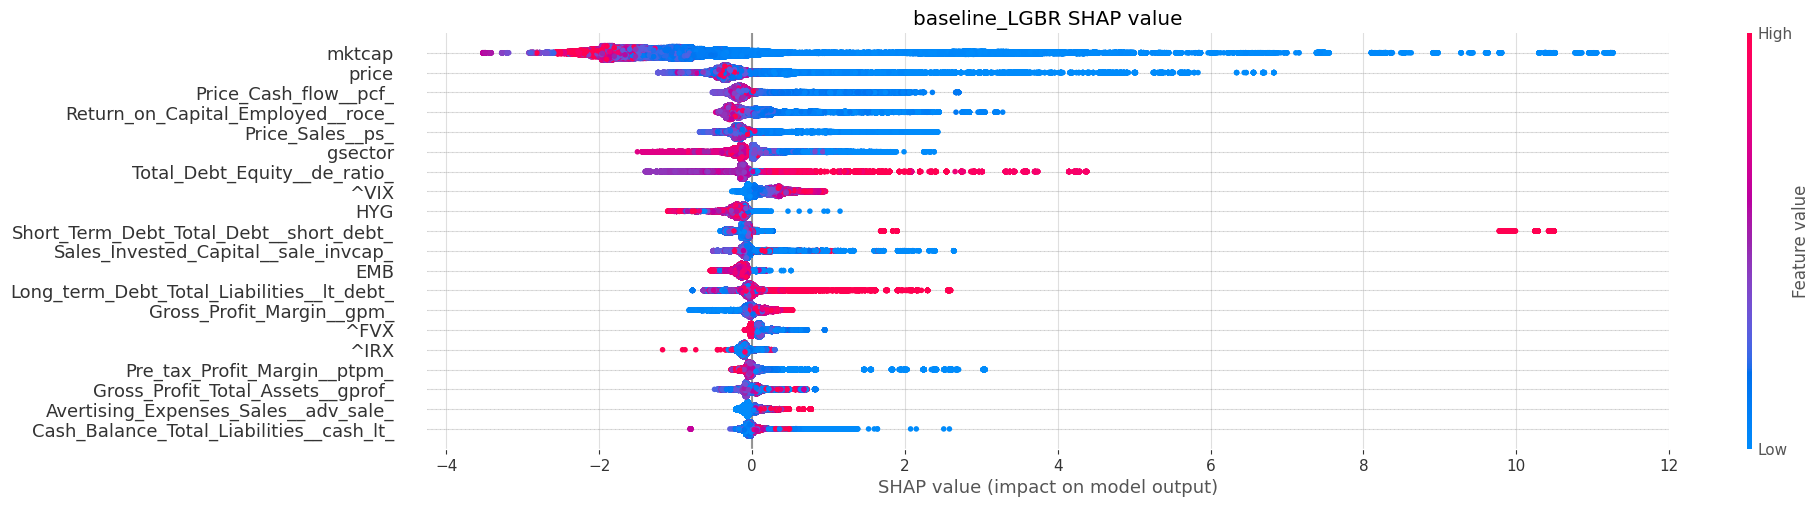

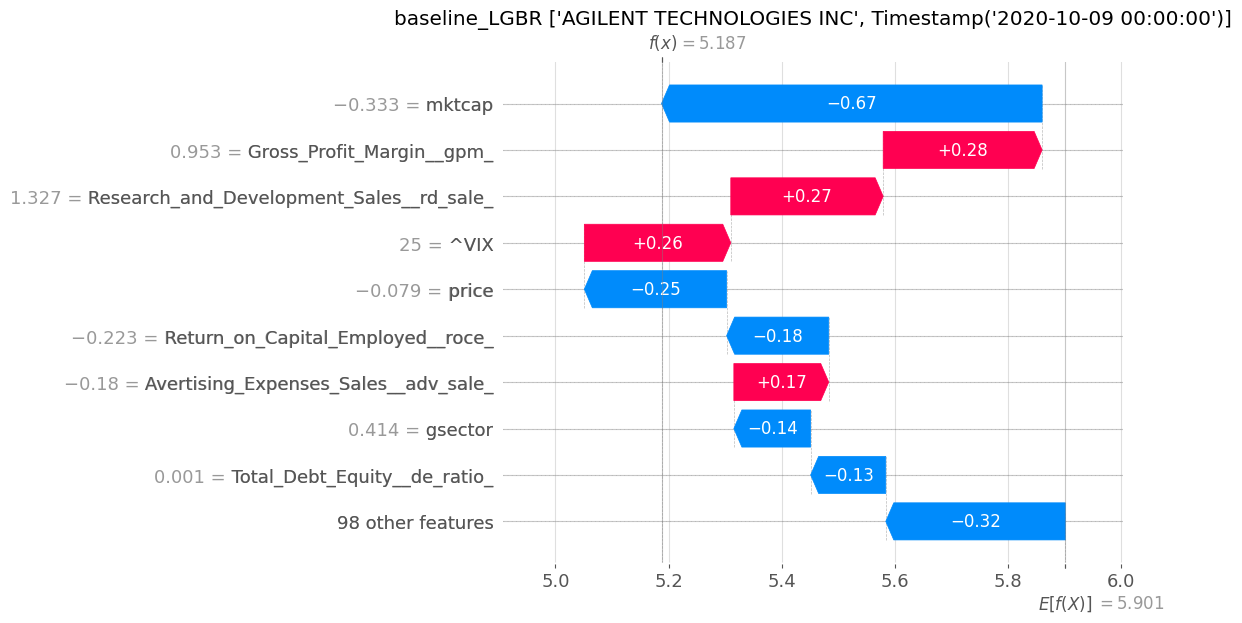

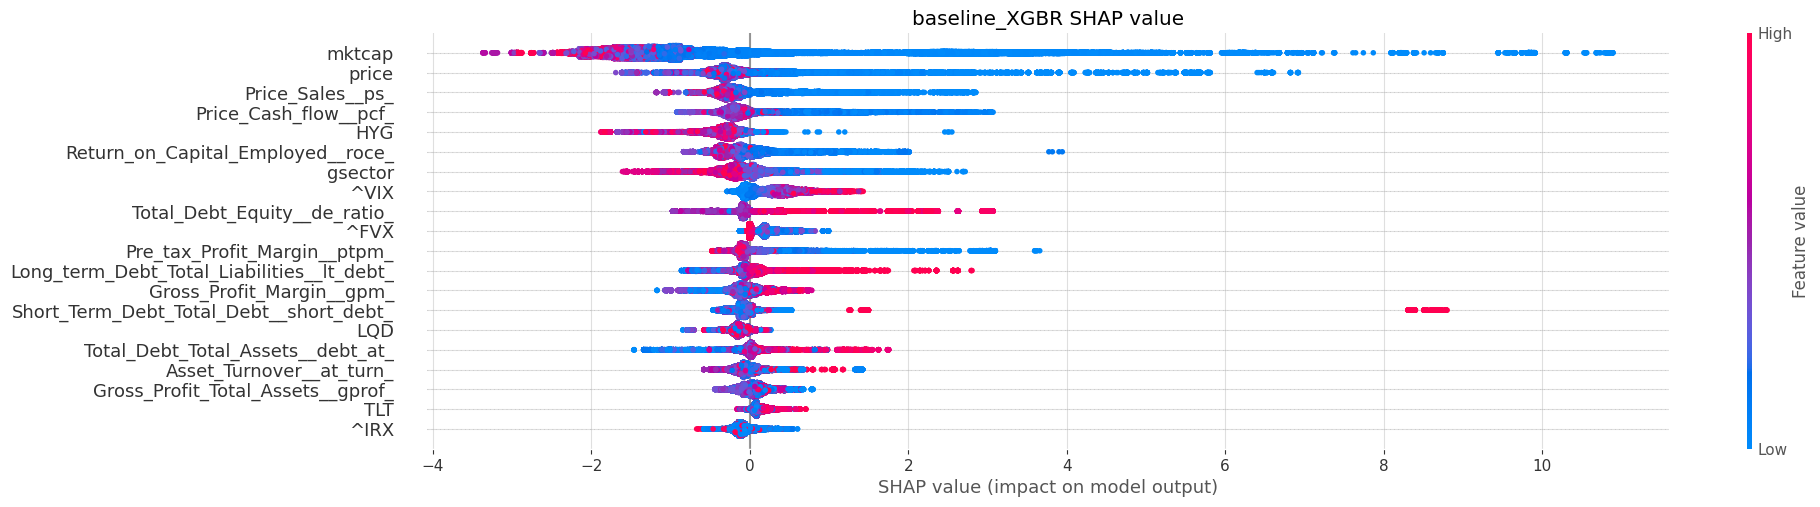

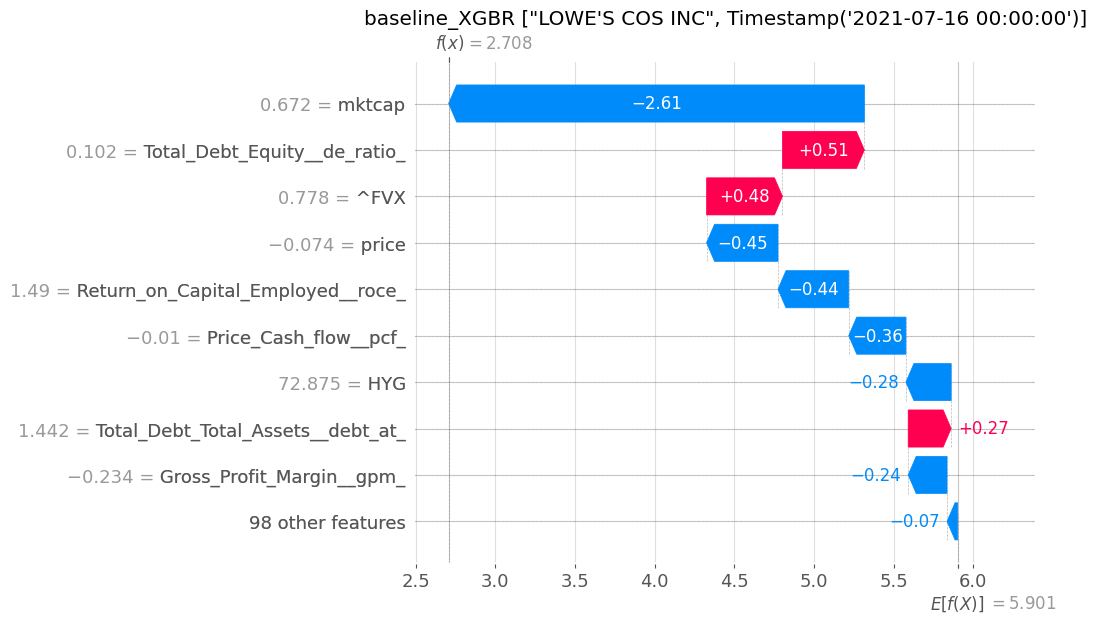

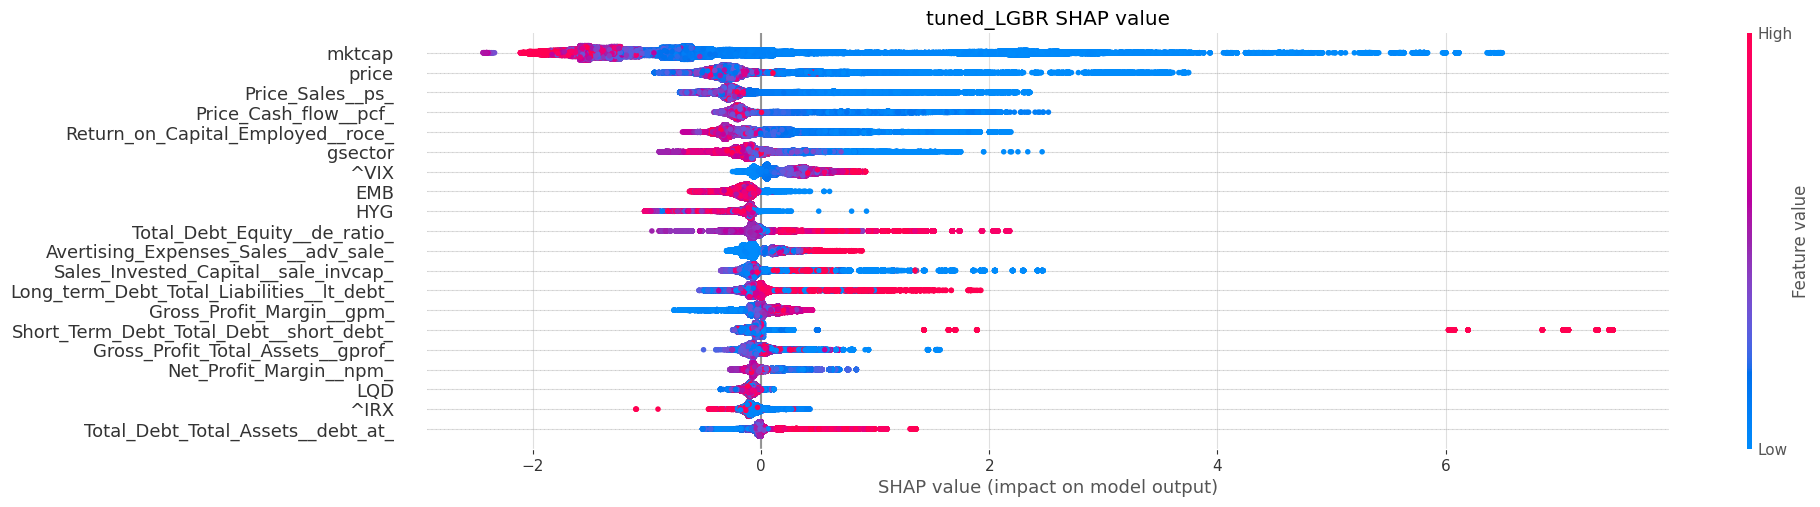

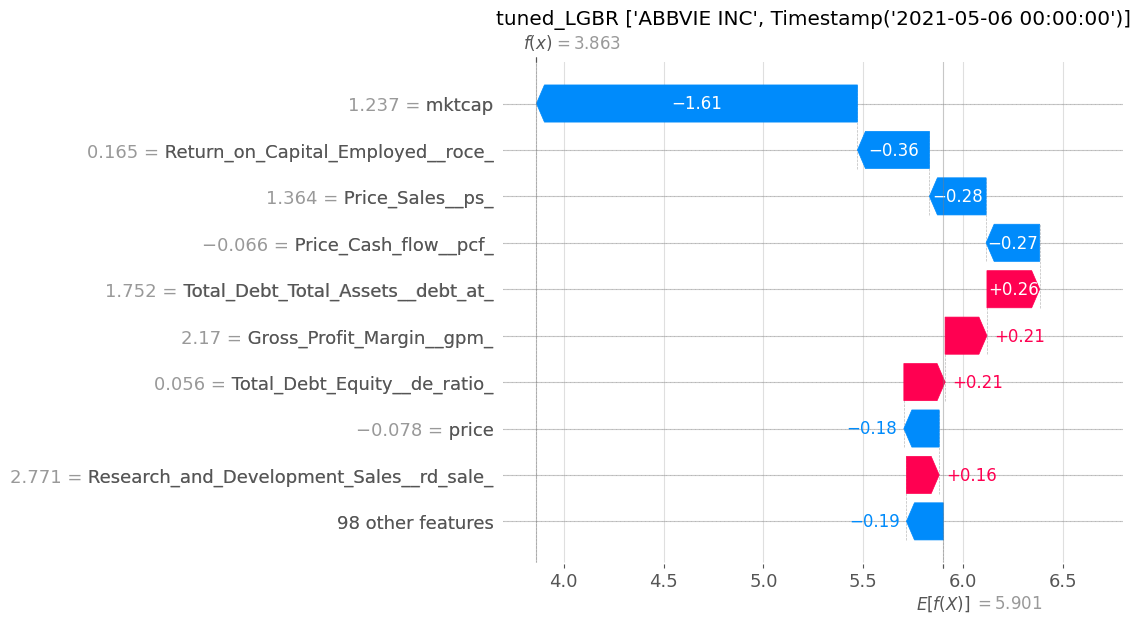

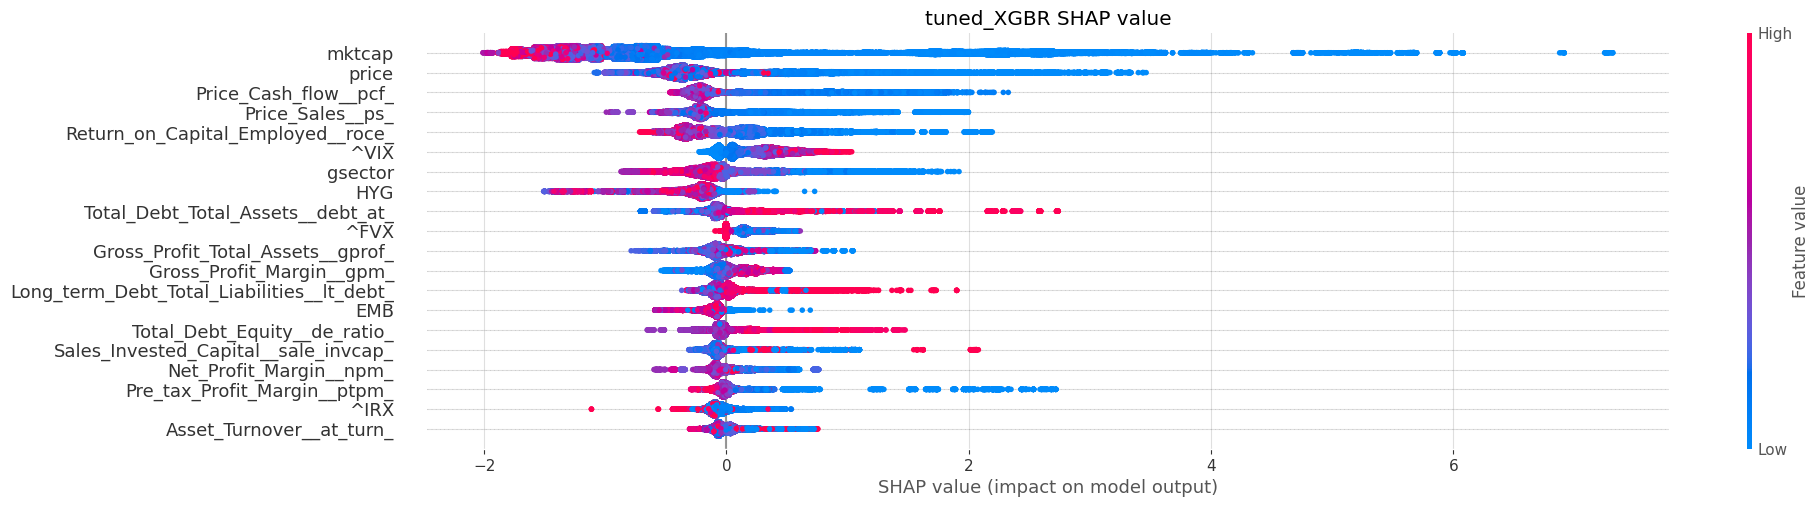

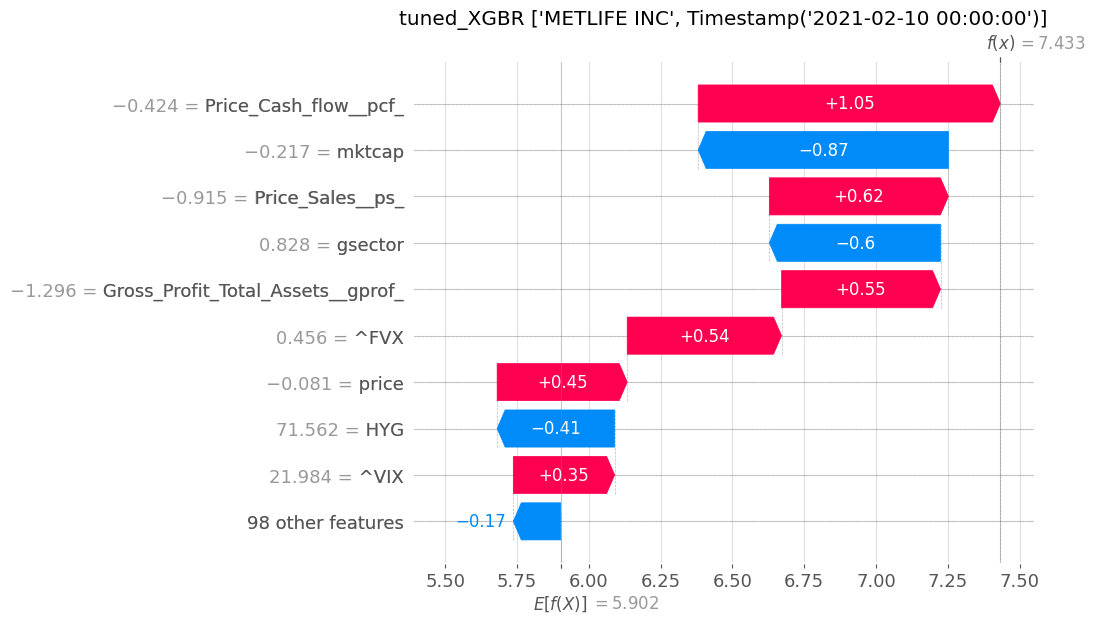

In [60]:
for name, model in zip(names, trained_model):
    if 'NN' not in name:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_size=[20, 5], show=False)
        plt.title(f"{name} SHAP value")
        plt.show()

        # Sample a row and see
        shap_values = explainer(X_test)
        shaply_test_explore = X_test.reset_index()

        row = np.random.randint(0, len(X_test))
        row_data = shaply_test_explore.loc[row, ["Company", "Date"]].tolist()

        shap.waterfall_plot(shap_values[row], show=False)
        plt.title(f"{name} {row_data}")
        plt.show()